# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off Speed RHP](#Off-Speed-RHP)
    - [Off Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv2022.csv', index_col = [0])
tu = pd.read_csv('../data/season23.csv')
tu = tu.loc[tu['PitcherTeam'] == 'TUS_PIO']
tu = tu[['Pitcher', 'PitcherThrows', 'TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
         'RelSide', 'RelHeight', 'Extension']]
tu['TaggedPitchType'].replace(['Fastball'], 'Four-Seam', inplace = True)
tu['TaggedPitchType'].replace(['FourSeamFastBall'], 'Four-Seam', inplace = True)
tu['TaggedPitchType'].replace(['TwoSeamFastBall'], 'Four-Seam', inplace = True)
tu.dropna(inplace=True)
pd.set_option('max_columns', None)
#data.dropna(inplace = True)
print(data.shape)
data.head()

(682572, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_rel_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_rel_outs_scale,woba,wraa_change,rv
0,"Zastryzny, Rob",L,FF,93.5,2451.0,167.0,-3.36,17.40,26.213904,94.6,-1.70,5.95,6.6,53.88,0.76,3.38,S,2,2,2-2,L,NaN,strike,field_out,NaN,NaN,NaN,0.0,1.0,NaN,78.0,6.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,1,1,0.0,0.0,0.0,0.11,-0.11,0.00,-0.11,-0.27,0.001,1.209,-0.326,0.001,0.269,-0.184,-0.110
1,"Zastryzny, Rob",L,CU,80.9,2266.0,273.0,13.44,-0.96,28.009889,81.1,-2.06,5.59,6.5,53.95,0.66,0.49,B,1,2,1-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,5.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,CU,35.2,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,0.032,0.032
2,"Zastryzny, Rob",L,FF,92.3,2321.0,157.0,-3.36,18.96,25.146262,92.8,-1.65,5.93,6.7,53.84,0.20,3.12,S,1,2,1-2,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,4.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,-0.152,-0.152
3,"Zastryzny, Rob",L,FF,94.3,2391.0,159.0,-4.80,17.28,25.355249,94.4,-1.65,5.93,6.4,54.09,-0.53,3.69,B,0,2,0-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,3.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.197,0.017,0.017
4,"Zastryzny, Rob",L,FF,93.4,2446.0,156.0,-3.60,18.00,26.188437,93.3,-1.81,5.93,6.4,54.13,0.62,2.19,S,0,1,0-1,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,2.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.265,-0.047,-0.047


In [3]:
tu.head()

,Pitcher,PitcherThrows,TaggedPitchType,RelSpeed,InducedVertBreak,HorzBreak,RelSide,RelHeight,Extension
0,"Salyards, Brady",Right,Four-Seam,87.3,12.7,16.7,2.3,5.8,6.3
1,"Salyards, Brady",Right,Four-Seam,86.4,17.6,13.3,2.2,5.7,6.3
2,"Salyards, Brady",Right,Slider,79.7,5.2,-4.7,2.0,5.8,6.1
3,"Salyards, Brady",Right,Slider,80.7,8.1,-5.8,2.1,5.8,5.9
4,"Salyards, Brady",Right,Four-Seam,87.5,14.1,14.0,2.3,5.6,6.4


# Features

**Independent Variables:** Velocity, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Run Value

### Multicolinearity - VIF

In [4]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'rv']]

features_tu = tu[['Pitcher', 'PitcherThrows', 'TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
                 'RelSide', 'RelHeight', 'Extension']]

#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

In [5]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

fb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Four-Seam'])]
bb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Slider', 'Cutter', 'Curveball'])]
os_tu = features_tu[features_tu['TaggedPitchType'].isin(['ChangeUp', 'Splitter'])]
rhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'R']
lhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'L']
rhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Right']
lhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Left']
rhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Right']
lhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Left']
rhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Right']
lhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Left']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [6]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.01


In [7]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.131
Cross Val Score: [0.0004304  0.0004494  0.00084627 0.00120621 0.00082103]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.131


- Average RHP FB Run Value prediction error is .26 runs

In [8]:
features_fb_r_tu = rhp_fb_tu.select_dtypes([np.number])
#features_fb_r_tu.dropna(inplace=True)
X_tu = features_fb_r_tu
pred_tu = lr.predict(X_tu)

In [9]:
pred_tu.shape

(2450,)

In [10]:
rhp_fb_tu['n_pitches'] = 1
rhp_fb_tu['xRV'] = pred_tu
rhp_fb_tu['xRV/100'] = round(((rhp_fb_tu['xRV'] / (rhp_fb_tu['n_pitches'])) * 100), 2)

rhp_fb_tu['Stuff+'] = (100 * (-rhp_fb_tu['xRV/100'] / -rhp_fb_tu['xRV/100'].mean()))
#rhp_fb.head()

grouped_fb_r_tu = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_fb_r_tu = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
fbr_stuff_tu = pd.merge(avg_fb_r_tu, grouped_fb_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

fbr_stuff_tu['xRV/100'] = round(((fbr_stuff_tu['xRV'] / (fbr_stuff_tu['n_pitches'])) * 100), 2)
#fbr_stuff_tu = fbr_stuff.loc[fbr_stuff['n_pitches'] >= 100]
fbr_stuff_tu = fbr_stuff_tu.round(1)
fbr_stuff_tu.insert(3, 'n_pitches', fbr_stuff_tu.pop('n_pitches'))
#fbr_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#fbr_stuff_tu.head(10)
#print(fbr_stuff_tu.to_markdown())

|    | Pitcher              | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:---------------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Absher, Luke         | Right           | Four-Seam         |         455 |       85.5 |        10   |               16.6 |       1.5 |         5.8 |         6.6 |     92.4 |   7.2 |       1.6 |
|  1 | Bonilla, Sam         | Right           | Four-Seam         |          80 |       87   |         6.4 |               14.9 |       2.1 |         5.8 |         6.6 |     88.4 |   1.2 |       1.5 |
|  2 | Fox Birdwell, Trejen | Right           | Four-Seam         |         273 |       87   |         9.6 |               13   |       3.1 |         5.8 |         5.8 |     70   |   3.3 |       1.2 |
|  3 | Nelson, Jonathan     | Right           | Four-Seam         |         156 |       85.1 |        12.6 |               16   |       0.8 |         5.3 |         6.1 |     66.1 |   1.8 |       1.1 |
|  4 | Ponder, Kohen        | Right           | Four-Seam         |          38 |       84.4 |         9.3 |               11.6 |       1.5 |         5.4 |         5.6 |     95.8 |   0.6 |       1.6 |
|  5 | Quinn, Billy         | Right           | Four-Seam         |         297 |       85.6 |        12   |               11.4 |       1.6 |         6.3 |         6.4 |     96.9 |   4.9 |       1.7 |
|  6 | Salyards, Brady      | Right           | Four-Seam         |         328 |       87   |        11   |               19.7 |       2   |         5.7 |         6.6 |     68.2 |   3.8 |       1.2 |
|  7 | Sliwinski, Drew      | Right           | Four-Seam         |         170 |       84.1 |         4.8 |               15.8 |       1.6 |         6   |         6.4 |    148.5 |   4.3 |       2.6 |
|  8 | White, Tyler         | Right           | Four-Seam         |          89 |       81.6 |         4.5 |               14.2 |       0.5 |         6.4 |         6.6 |    203.2 |   3.1 |       3.5 |
|  9 | Willett, Jacob       | Right           | Four-Seam         |         166 |       86.4 |         6   |               20.5 |       1   |         6.1 |         6.5 |    123   |   3.5 |       2.1 |
| 10 | Willis, Seth         | Right           | Four-Seam         |         398 |       86.4 |        11.5 |               20.4 |       0.6 |         6.5 |         5.4 |    120.6 |   8.2 |       2.1 |

### RHP Fastball xRV by HB & VB

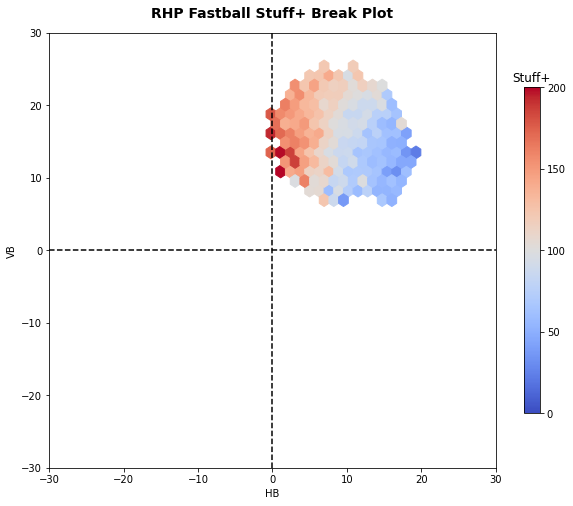

In [11]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_fb_tu['HorzBreak'], rhp_fb_tu['InducedVertBreak'], C = rhp_fb_tu['Stuff+'], cmap = 'coolwarm', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Stuff+ Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
#print('RHP Fastball Avg Stuff+:', round(rhp_fb['Stuff+'].mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [12]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: -0.01


In [13]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.13
Cross Val Score: [ 8.28537067e-04  3.84167253e-04 -9.28805082e-04  8.56752915e-05
  7.42803280e-04]
Cross Val Score: 0.0 

R2 Score: 0.001
RMSE: 0.253
MAE: 0.13


In [14]:
features_fb_l_tu = lhp_fb_tu.select_dtypes([np.number])
#features_fb_l_tu.dropna(inplace=True)
X_tu = features_fb_l_tu
pred_tu = lr.predict(X_tu)

- Average LHP FB Run Value prediction error is .26 runs

### LHP Fastball Actual & Predicted Values

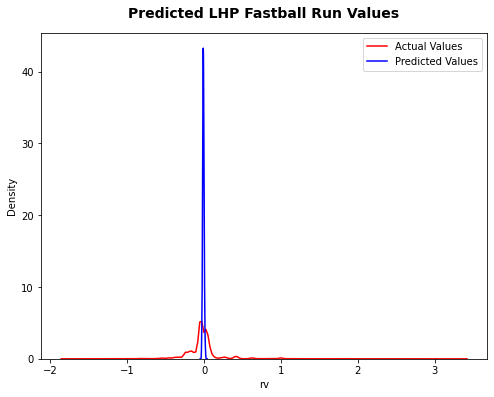

In [15]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [16]:
lhp_fb_tu['n_pitches'] = 1
lhp_fb_tu['xRV'] = pred_tu
lhp_fb_tu['xRV/100'] = round(((lhp_fb_tu['xRV'] / (lhp_fb_tu['n_pitches'])) * 100), 2)

lhp_fb_tu['Stuff+'] = (100 * (-lhp_fb_tu['xRV/100'] / -lhp_fb_tu['xRV/100'].mean()))
#lhp_fb.head()

grouped_fb_l_tu = lhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_fb_l_tu = lhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
fbl_stuff_tu = pd.merge(avg_fb_l_tu, grouped_fb_l_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

fbl_stuff_tu['xRV/100'] = round(((fbl_stuff_tu['xRV'] / (fbl_stuff_tu['n_pitches'])) * 100), 2)
#fbr_stuff_tu = fbr_stuff.loc[fbr_stuff['n_pitches'] >= 100]
fbl_stuff_tu = fbl_stuff_tu.round(1)
fbl_stuff_tu.insert(3, 'n_pitches', fbl_stuff_tu.pop('n_pitches'))
#fbr_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
fbl_stuff_tu.head(10)
print(fbl_stuff_tu.to_markdown())

|    | Pitcher       | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:--------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Crosby, Alex  | Left            | Four-Seam         |         125 |       81.1 |       -10.9 |               11   |      -1.2 |         5.5 |         5.5 |    101.4 |   4.6 |       3.7 |
|  1 | Martin, Scout | Left            | Four-Seam         |          45 |       80.2 |        -7.7 |               19.2 |      -1.3 |         5.7 |         5.5 |     96   |   1.6 |       3.5 |


|    | Pitcher       | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:--------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  1 | Martin, Scout | Left            | Four-Seam         |          45 |       80.2 |        -7.7 |               19.2 |      -1.3 |         5.7 |         5.5 |     96   |   1.6 |       3.5 |

### LHP Fastball xRV by HB & VB

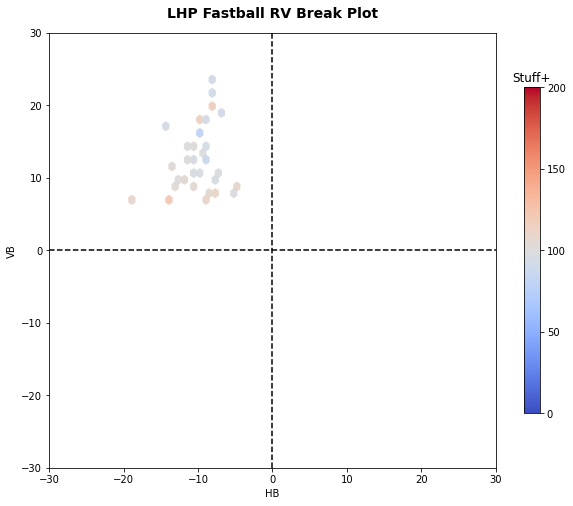

In [17]:
plt.figure(figsize = (10, 8))
plt.hexbin(lhp_fb_tu['HorzBreak'], lhp_fb_tu['InducedVertBreak'], C = lhp_fb_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Cutter, Curveball, Knuckle Curve

In [18]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.02


In [19]:
rhp_bb.dropna(inplace = True)
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.125
Cross Val Score: [1.03171913e-03 1.05936146e-05 1.06687632e-03 1.45397342e-04
 4.77186923e-04]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.248
MAE: 0.126


In [20]:
features_bb_r_tu = rhp_bb_tu.select_dtypes([np.number])
#features_bb_r_tu.dropna(inplace=True)
X_tu = features_bb_r_tu
pred_tu = lr.predict(X_tu)

In [21]:
rhp_bb_tu['n_pitches'] = 1
rhp_bb_tu['xRV'] = pred_tu
rhp_bb_tu['xRV/100'] = round(((rhp_bb_tu['xRV'] / (rhp_bb_tu['n_pitches'])) * 100), 2)

rhp_bb_tu['Stuff+'] = (100 * (-rhp_bb_tu['xRV/100'] / -rhp_bb_tu['xRV/100'].mean()))
#rhp_bb.head()

grouped_bb_r_tu = rhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_bb_r_tu = rhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
bbr_stuff_tu = pd.merge(avg_bb_r_tu, grouped_bb_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

bbr_stuff_tu['xRV/100'] = round(((bbr_stuff_tu['xRV'] / (bbr_stuff_tu['n_pitches'])) * 100), 2)
#bbr_stuff_tu = bbr_stuff.loc[bbr_stuff['n_pitches'] >= 100]
bbr_stuff_tu = bbr_stuff_tu.round(1)
bbr_stuff_tu.insert(3, 'n_pitches', bbr_stuff_tu.pop('n_pitches'))
#bbr_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#bbr_stuff_tu.head(10)
#print(bbr_stuff_tu.to_markdown())

|    | Pitcher              | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:---------------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Absher, Luke         | Right           | Curveball         |          37 |       73.6 |        -8   |               -1.9 |       1.8 |         5.7 |         5.8 |   -172.4 |   0   |       0   |
|  1 | Absher, Luke         | Right           | Slider            |          95 |       74.2 |        -7.7 |                0   |       1.8 |         5.6 |         5.9 |   -909.5 |   0.2 |       0.2 |
|  2 | Bonilla, Sam         | Right           | Curveball         |           1 |       72.9 |       -15.2 |              -15.1 |       3   |         5.7 |         5.6 |   5765.7 |  -0   |      -1.4 |
|  3 | Bonilla, Sam         | Right           | Slider            |          26 |       75.6 |       -12.9 |               -3.2 |       2.3 |         5.7 |         5.8 |   2225.5 |  -0.1 |      -0.5 |
|  4 | Fox Birdwell, Trejen | Right           | Curveball         |           9 |       76.1 |        -3.3 |               -3.7 |       2.9 |         5.8 |         5.7 |   -286.2 |   0   |       0.1 |
|  5 | Fox Birdwell, Trejen | Right           | Slider            |         103 |       77.5 |        -7.5 |               -1.7 |       3.1 |         5.7 |         5.5 |    626.5 |  -0.2 |      -0.2 |
|  6 | Nelson, Jonathan     | Right           | Curveball         |           8 |       73.4 |        -5.6 |               -6.5 |       0.9 |         5.3 |         5.5 |   3629.1 |  -0.1 |      -0.9 |
|  7 | Nelson, Jonathan     | Right           | Slider            |          36 |       74.4 |        -8.2 |               -5.1 |       0.9 |         5.2 |         5.5 |   4367.5 |  -0.4 |      -1.1 |
|  8 | Ponder, Kohen        | Right           | Curveball         |          18 |       67.4 |       -21.1 |               -2.9 |       1.5 |         5.4 |         5   |    674.7 |  -0   |      -0.2 |
|  9 | Ponder, Kohen        | Right           | Slider            |          10 |       69.6 |       -18.6 |               -2.6 |       1.4 |         5.5 |         5   |   1639.8 |  -0   |      -0.4 |
| 10 | Quinn, Billy         | Right           | Curveball         |          12 |       72.6 |        -7.2 |               -1.7 |       1.6 |         6.1 |         5.9 |  -1335.8 |   0   |       0.3 |
| 11 | Quinn, Billy         | Right           | Slider            |          84 |       76.4 |        -7   |               -0.2 |       1.7 |         6.1 |         5.9 |    194.7 |  -0   |      -0   |
| 12 | Salyards, Brady      | Right           | Curveball         |          37 |       70   |       -12.3 |              -11.8 |       1.6 |         5.9 |         5.9 |   3027.1 |  -0.3 |      -0.7 |
| 13 | Salyards, Brady      | Right           | Cutter            |          94 |       78.7 |        -4.6 |                6.2 |       2.1 |         5.6 |         6.2 |  -2353.9 |   0.5 |       0.6 |
| 14 | Salyards, Brady      | Right           | Slider            |          68 |       78   |        -5.8 |                4   |       2   |         5.7 |         6.2 |  -1347   |   0.2 |       0.3 |
| 15 | Sliwinski, Drew      | Right           | Curveball         |          98 |       78.5 |        -1.3 |               -0.9 |       1.8 |         5.9 |         5.9 |    784.9 |  -0.2 |      -0.2 |
| 16 | Sliwinski, Drew      | Right           | Slider            |          30 |       77.5 |        -2   |               -0.9 |       1.9 |         5.8 |         6.1 |     30   |  -0   |      -0   |
| 17 | White, Tyler         | Right           | Curveball         |          23 |       70.5 |        -5   |                4.8 |       0.5 |         6.3 |         6.3 |  -5634.2 |   0.3 |       1.4 |
| 18 | White, Tyler         | Right           | Cutter            |           2 |       76.2 |         0   |               10.4 |       0.6 |         6.4 |         6.6 |  -6133.8 |   0   |       1.5 |
| 19 | White, Tyler         | Right           | Slider            |          35 |       72.5 |        -3.1 |                6.1 |       0.5 |         6.3 |         6.5 |  -5348.6 |   0.5 |       1.3 |
| 20 | Willett, Jacob       | Right           | Curveball         |          27 |       74.5 |        -8.1 |                2   |       1.2 |         6   |         5.9 |  -1131.3 |   0.1 |       0.3 |
| 21 | Willett, Jacob       | Right           | Cutter            |           1 |       84   |        -5.5 |               16.6 |       0.7 |         6.2 |         6.6 |  -2617.1 |   0   |       0.6 |
| 22 | Willett, Jacob       | Right           | Slider            |          67 |       75.9 |        -8.5 |                3   |       1   |         6   |         5.9 |   -180   |   0   |       0   |
| 23 | Willis, Seth         | Right           | Curveball         |         137 |       71.7 |        -0.8 |               -9.3 |       0.6 |         6.5 |         5.1 |   2473.8 |  -0.8 |      -0.6 |
| 24 | Willis, Seth         | Right           | Slider            |          15 |       73.3 |         1.3 |               -5.3 |       0.6 |         6.5 |         5.1 |   1185.9 |  -0   |      -0.3 |

- Average RHP Breaking Ball Run Value prediction error is .26 runs

### RHP Breaking Ball Actual & Predicted Values

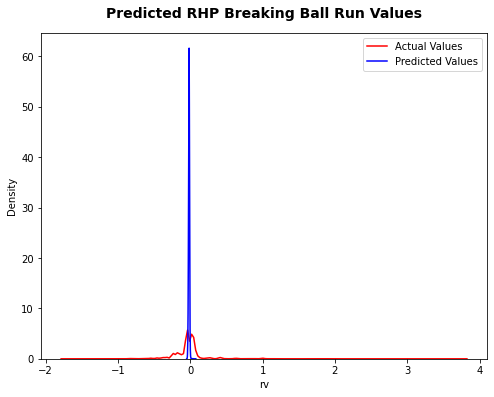

In [22]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

### RHP Breaking Ball xRV by HB & VB

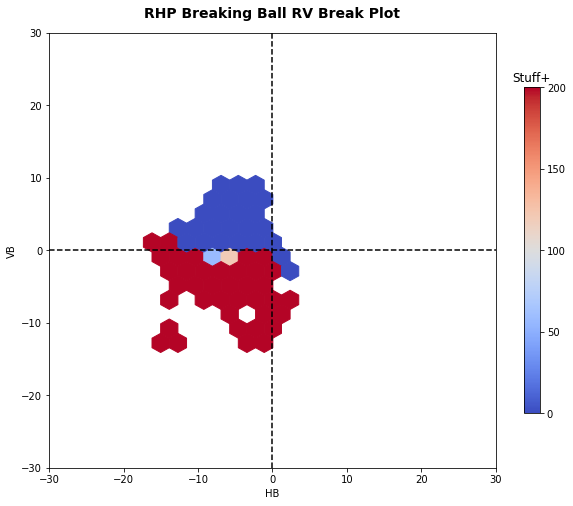

In [23]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb_tu['HorzBreak'], rhp_bb_tu['InducedVertBreak'], C = rhp_bb_tu['Stuff+'],cmap='coolwarm',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [24]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.02


In [25]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.127
Cross Val Score: [-0.0019186  -0.000218   -0.00057317 -0.00141016  0.00105717]
Cross Val Score: -0.001 

R2 Score: 0.001
RMSE: 0.252
MAE: 0.129


In [26]:
features_bb_r_tu = lhp_bb_tu.select_dtypes([np.number])
#features_bb_r_tu.dropna(inplace=True)
X_tu = features_bb_r_tu
pred_tu = lr.predict(X_tu)

In [27]:
lhp_bb_tu['n_pitches'] = 1
lhp_bb_tu['xRV'] = pred_tu
lhp_bb_tu['xRV/100'] = round(((lhp_bb_tu['xRV'] / (lhp_bb_tu['n_pitches'])) * 100), 2)

lhp_bb_tu['Stuff+'] = (100 * (-lhp_bb_tu['xRV/100'] / -lhp_bb_tu['xRV/100'].mean()))
#lhp_bb.head()

grouped_bb_r_tu = lhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_bb_r_tu = lhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
bbl_stuff_tu = pd.merge(avg_bb_r_tu, grouped_bb_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

bbl_stuff_tu['xRV/100'] = round(((bbl_stuff_tu['xRV'] / (bbl_stuff_tu['n_pitches'])) * 100), 2)
#bbl_stuff_tu = bbl_stuff.loc[bbl_stuff['n_pitches'] >= 100]
bbl_stuff_tu = bbl_stuff_tu.round(1)
bbl_stuff_tu.insert(3, 'n_pitches', bbl_stuff_tu.pop('n_pitches'))
#bbl_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#bbl_stuff_tu.head(10)
#print(bbl_stuff_tu.to_markdown())

|    | Pitcher       | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:--------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Crosby, Alex  | Left            | Curveball         |           7 |       71.3 |         8.5 |                2.7 |      -1.2 |         5.6 |         4.9 |      2.2 |  -0   |      -0   |
|  1 | Crosby, Alex  | Left            | Slider            |          36 |       73.5 |         4.5 |                4.1 |      -1.3 |         5.4 |         5.1 |    110.4 |  -0.3 |      -0.8 |
|  2 | Martin, Scout | Left            | Curveball         |           9 |       72.6 |         8.2 |               -0.2 |      -1.3 |         5.8 |         5.2 |     93.7 |  -0.1 |      -0.7 |
|  3 | Martin, Scout | Left            | Slider            |           6 |       72.7 |         6.5 |                0.3 |      -1.2 |         5.8 |         5.5 |    161   |  -0.1 |      -1.1 |

- Average LHP Breaking Ball Run Value prediction error is .26 runs

### LHP Breaking Ball Actual & Predicted Values

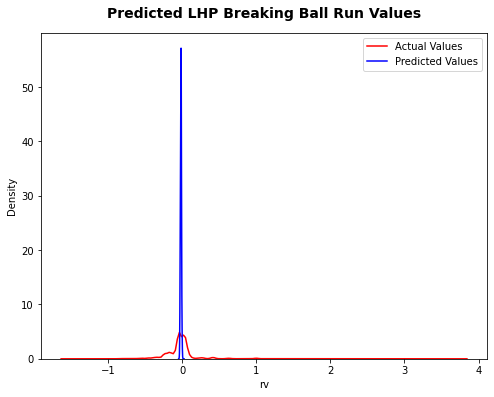

In [28]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

### LHP Breaking Ball xRV by HB & VB

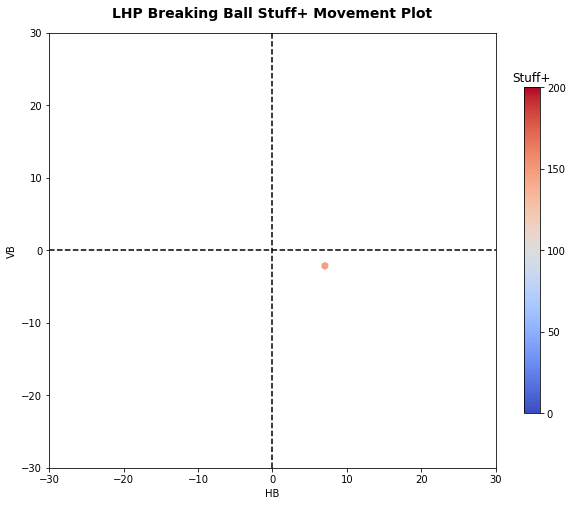

In [29]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb_tu['HorzBreak'], lhp_bb_tu['InducedVertBreak'], C = lhp_bb_tu['Stuff+'],cmap='coolwarm', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
#print('LHP Breaking Ball Avgerage Stuff+:', round(lhp_bb['Stuff+'].mean(), 2))

## Off Speed RHP

#### Changeup, Splitter

In [30]:
print('Baseline RHP Off Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off Speed RunValue Accuracy Score: -0.02


In [31]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.0
Test RMSE: 0.258
Test MAE: 0.137
Cross Val Score: [ 0.00058021 -0.00036001 -0.00129048  0.00045615  0.00019638]
Cross Val Score: -0.0 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.136


In [32]:
features_os_r_tu = rhp_os_tu.select_dtypes([np.number])
#features_os_r_tu.dropna(inplace=True)
X_tu = features_os_r_tu
pred_tu = lr.predict(X_tu)

In [33]:
rhp_os_tu['n_pitches'] = 1
rhp_os_tu['xRV'] = pred_tu
rhp_os_tu['xRV/100'] = round(((rhp_os_tu['xRV'] / (rhp_os_tu['n_pitches'])) * 100), 2)

rhp_os_tu['Stuff+'] = (100 * (-rhp_os_tu['xRV/100'] / -rhp_os_tu['xRV/100'].mean()))
#rhp_os.head()

grouped_os_r_tu = rhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_os_r_tu = rhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
osr_stuff_tu = pd.merge(avg_os_r_tu, grouped_os_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

osr_stuff_tu['xRV/100'] = round(((osr_stuff_tu['xRV'] / (osr_stuff_tu['n_pitches'])) * 100), 2)
#osr_stuff_tu = osr_stuff.loc[osr_stuff['n_pitches'] >= 100]
osr_stuff_tu = osr_stuff_tu.round(1)
osr_stuff_tu.insert(3, 'n_pitches', osr_stuff_tu.pop('n_pitches'))
#osr_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#osr_stuff_tu.head(10)
#print(osr_stuff_tu.to_markdown())

|    | Pitcher              | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:---------------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Absher, Luke         | Right           | ChangeUp          |         140 |       75.9 |         8.6 |                9.6 |       1.8 |         5.5 |         6.4 |    159.2 |  -0.6 |      -0.4 |
|  1 | Absher, Luke         | Right           | Splitter          |          71 |       75.8 |         5.2 |                7.1 |       1.7 |         5.7 |         6.2 |    410.5 |  -0.8 |      -1.1 |
|  2 | Bonilla, Sam         | Right           | ChangeUp          |           1 |       83.2 |         9.2 |               22.2 |       1.8 |         5.9 |         6.2 |    349   |  -0   |      -1   |
|  3 | Fox Birdwell, Trejen | Right           | ChangeUp          |           2 |       79.8 |         7.2 |                2.4 |       3.4 |         5.7 |         5.7 |    -18   |   0   |       0   |
|  4 | Fox Birdwell, Trejen | Right           | Splitter          |          39 |       79.4 |         6.6 |                2.2 |       3   |         5.8 |         5.7 |     64.6 |  -0.1 |      -0.2 |
|  5 | Nelson, Jonathan     | Right           | ChangeUp          |          87 |       77.2 |        15.9 |                8.6 |       0.9 |         5.1 |         6.1 |   -482.1 |   1.2 |       1.3 |
|  6 | Ponder, Kohen        | Right           | ChangeUp          |           1 |       81.1 |         1.7 |                8.1 |       1.7 |         5.4 |         5.3 |    316.6 |  -0   |      -0.9 |
|  7 | Quinn, Billy         | Right           | ChangeUp          |          20 |       76.6 |        11   |                8.6 |       1.7 |         6   |         6.3 |    186.2 |  -0.1 |      -0.5 |
|  8 | Quinn, Billy         | Right           | Splitter          |           1 |       77.9 |         7.1 |               16.6 |       1.8 |         6.2 |         6.3 |    554   |  -0   |      -1.5 |
|  9 | Salyards, Brady      | Right           | ChangeUp          |           6 |       77   |         5.1 |               13.3 |       1.9 |         5.9 |         6.4 |    542.6 |  -0.1 |      -1.5 |
| 10 | Salyards, Brady      | Right           | Splitter          |          89 |       77   |         6.6 |               14.5 |       1.8 |         5.9 |         6.2 |    401.5 |  -1   |      -1.1 |
| 11 | Sliwinski, Drew      | Right           | ChangeUp          |         113 |       79.2 |         5.5 |               14.2 |       1.9 |         5.9 |         6.1 |    452.7 |  -1.4 |      -1.3 |
| 12 | Sliwinski, Drew      | Right           | Splitter          |           1 |       79.5 |        -3.9 |               12.9 |       2.1 |         5.7 |         6.4 |   1075.6 |  -0   |      -3   |
| 13 | White, Tyler         | Right           | ChangeUp          |          13 |       73.1 |         2.6 |               13.8 |       0.5 |         6.2 |         6.9 |   1086.1 |  -0.4 |      -3   |
| 14 | Willett, Jacob       | Right           | ChangeUp          |           5 |       78.5 |         0.9 |               12.5 |       1.3 |         5.9 |         6.3 |    894.3 |  -0.1 |      -2.5 |
| 15 | Willett, Jacob       | Right           | Splitter          |          24 |       76.8 |         1.5 |                5.8 |       1.3 |         5.9 |         5.9 |    701.8 |  -0.5 |      -2   |
| 16 | Willis, Seth         | Right           | ChangeUp          |         227 |       78.7 |        18.3 |               16.2 |       0.8 |         6.4 |         5.3 |   -262.4 |   1.7 |       0.7 |

- Average RHP Off Speed Run Value prediction error is .26 runs

### RHP Off Speed Actual & Predicted Run Values

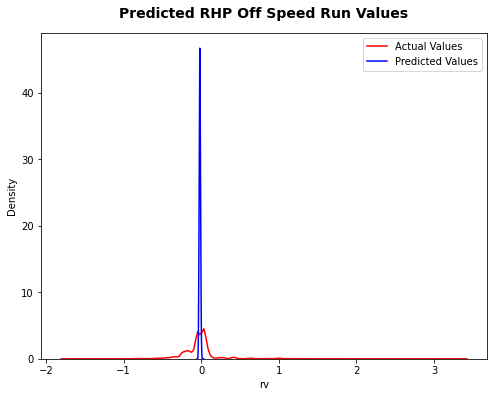

In [34]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off Speed RV Table

### RHP Off Speed xRV by HB & VB

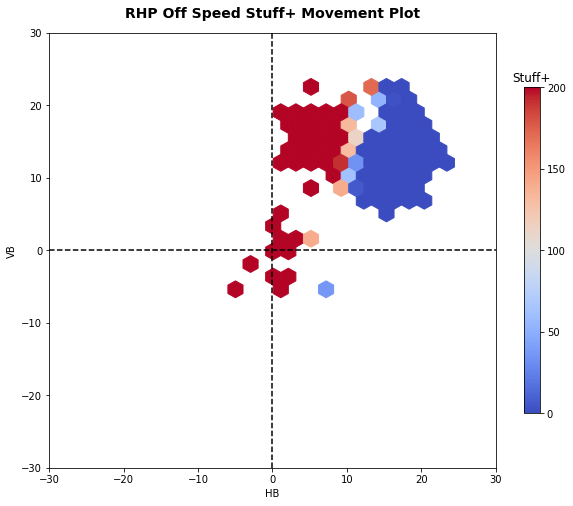

In [35]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os_tu['HorzBreak'], rhp_os_tu['InducedVertBreak'], C = rhp_os_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
#print('RHP Off Speed Avg Stuff+:', round(rhp_os['Stuff+'].mean(), 2))

## Off Speed LHP
#### Changeup, Splitter

In [36]:
print('Baseline LHP Off Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off Speed RunValue Accuracy Score: -0.01


In [37]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.275
Test MAE: 0.142
Cross Val Score: [ 0.00022675 -0.00549067  0.00116623 -0.00410241  0.00130452]
Cross Val Score: -0.001 

R2 Score: 0.001
RMSE: 0.262
MAE: 0.138


In [38]:
features_os_r_tu = lhp_os_tu.select_dtypes([np.number])
#features_os_r_tu.dropna(inplace=True)
X_tu = features_os_r_tu
pred_tu = lr.predict(X_tu)

In [39]:
lhp_os_tu['n_pitches'] = 1
lhp_os_tu['xRV'] = pred_tu
lhp_os_tu['xRV/100'] = round(((lhp_os_tu['xRV'] / (lhp_os_tu['n_pitches'])) * 100), 2)

lhp_os_tu['Stuff+'] = (100 * (-lhp_os_tu['xRV/100'] / -lhp_os_tu['xRV/100'].mean()))
#lhp_os.head()

grouped_os_r_tu = lhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_os_r_tu = lhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
osl_stuff_tu = pd.merge(avg_os_r_tu, grouped_os_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

osl_stuff_tu['xRV/100'] = round(((osl_stuff_tu['xRV'] / (osl_stuff_tu['n_pitches'])) * 100), 2)
#osl_stuff_tu = osl_stuff.loc[osl_stuff['n_pitches'] >= 100]
osl_stuff_tu = osl_stuff_tu.round(1)
osl_stuff_tu.insert(3, 'n_pitches', osl_stuff_tu.pop('n_pitches'))
#osl_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#osl_stuff_tu.head(10)
#print(osl_stuff_tu.to_markdown())

|    | Pitcher       | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |   xRV/100 |
|---:|:--------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|----------:|
|  0 | Crosby, Alex  | Left            | ChangeUp          |           8 |       74.6 |         5   |                4.2 |      -1.4 |         5.3 |         5.1 |    133.5 |     0 |       0.6 |
|  1 | Martin, Scout | Left            | ChangeUp          |          11 |       73.9 |        -4.8 |               13.9 |      -1.4 |         5.6 |         5.8 |     75.6 |     0 |       0.4 |

- Average RHP Off Speed Run Value prediction error is .27 runs

### LHP Off Speed Actual & Predicted Values

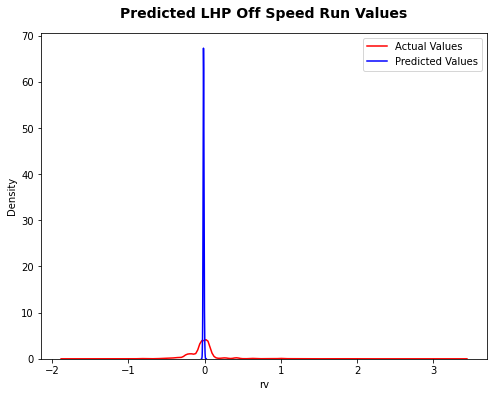

In [40]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off Speed RV Table

### LHP Off Speed xRV by HB & VB

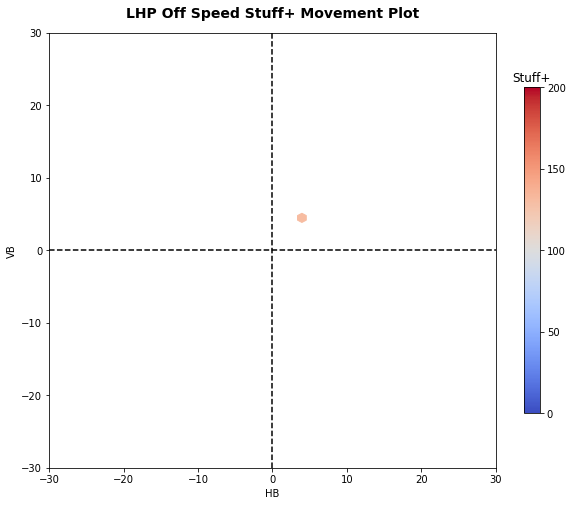

In [41]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os_tu['HorzBreak'], lhp_os_tu['InducedVertBreak'], C = lhp_os_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
#print('LHP Off Speed Avg Stuff+:', round(lhp_os['Stuff+'].mean(), 2))